# Semi-Supervised Learning: Movie Revenue Tier Prediction

## Motivation
Our TMDB dataset has **72% missing revenue data** — only ~2,600 of 9,290 movies have known revenue.  
This makes it a **perfect candidate for semi-supervised learning**, which leverages both labeled and unlabeled data to build better models than purely supervised approaches.

## Approach
1. **Target**: Revenue Tier classification (Low / Medium / High / Blockbuster)
2. **Labeled data**: Movies with known revenue (~28%)
3. **Unlabeled data**: Movies without revenue (~72%)
4. **Models**:
   - **Baseline**: Supervised-only (trained on labeled data only)
   - **Self-Training Classifier**: Semi-supervised wrapper using high-confidence pseudo-labels
   - **Label Propagation**: Graph-based semi-supervised method
   - **Label Spreading**: Regularized variant of Label Propagation
5. **Evaluation**: Compare all approaches on a held-out test set from the labeled data

In [1]:
# ----- Imports & Setup -----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.semi_supervised import SelfTrainingClassifier, LabelPropagation, LabelSpreading
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)
print('All imports loaded successfully.')

All imports loaded successfully.


## 1. Data Loading & Target Engineering

In [2]:
# Load the cleaned & engineered dataset
df = pd.read_csv('../data/data_cleaned_engineered.csv')
print(f'Dataset shape: {df.shape}')
print(f'Movies with revenue > 0: {(df["revenue"] > 0).sum()}')
print(f'Movies with revenue missing/zero: {(df["revenue"].isna() | (df["revenue"] == 0)).sum()}')
print(f'Proportion labeled: {(df["revenue"] > 0).mean():.1%}')

Dataset shape: (9290, 122)
Movies with revenue > 0: 2604
Movies with revenue missing/zero: 6686
Proportion labeled: 28.0%


In [3]:
# Create Revenue Tier target variable from movies with known revenue
labeled_mask = df['revenue'] > 0
revenue_values = df.loc[labeled_mask, 'revenue']

# Define tiers using quartiles of known revenue
q25, q50, q75 = revenue_values.quantile([0.25, 0.50, 0.75])
print(f'Revenue quartiles:')
print(f'  Q25: ${q25:,.0f}')
print(f'  Q50: ${q50:,.0f}')
print(f'  Q75: ${q75:,.0f}')

def assign_tier(rev):
    if pd.isna(rev) or rev <= 0:
        return -1  # Unlabeled
    elif rev <= q25:
        return 0   # Low
    elif rev <= q50:
        return 1   # Medium
    elif rev <= q75:
        return 2   # High
    else:
        return 3   # Blockbuster

df['revenue_tier'] = df['revenue'].apply(assign_tier)

tier_names = {-1: 'Unlabeled', 0: 'Low', 1: 'Medium', 2: 'High', 3: 'Blockbuster'}
print(f'\nTier distribution:')
for tier, name in tier_names.items():
    count = (df['revenue_tier'] == tier).sum()
    print(f'  {name}: {count} ({count/len(df):.1%})')

Revenue quartiles:
  Q25: $3,553,760
  Q50: $33,749,242
  Q75: $140,441,440

Tier distribution:
  Unlabeled: 6686 (72.0%)
  Low: 651 (7.0%)
  Medium: 651 (7.0%)
  High: 651 (7.0%)
  Blockbuster: 651 (7.0%)


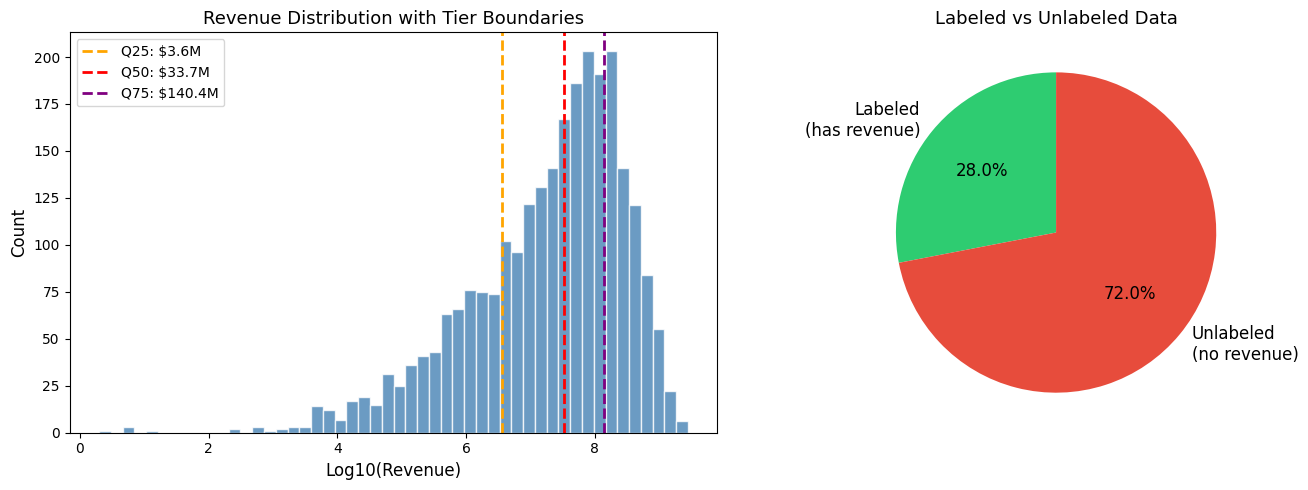


This 72% unlabeled ratio is ideal for semi-supervised learning!


In [4]:
# Visualize the tier distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Revenue distribution with tier boundaries
ax1 = axes[0]
ax1.hist(np.log10(revenue_values), bins=50, color='steelblue', edgecolor='white', alpha=0.8)
for q, label, color in [(q25, 'Q25', 'orange'), (q50, 'Q50', 'red'), (q75, 'Q75', 'purple')]:
    ax1.axvline(np.log10(q), color=color, linestyle='--', linewidth=2, label=f'{label}: ${q/1e6:.1f}M')
ax1.set_xlabel('Log10(Revenue)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Revenue Distribution with Tier Boundaries', fontsize=13)
ax1.legend()

# Right: Labeled vs Unlabeled pie chart
ax2 = axes[1]
labeled_count = labeled_mask.sum()
unlabeled_count = len(df) - labeled_count
ax2.pie([labeled_count, unlabeled_count], labels=['Labeled\n(has revenue)', 'Unlabeled\n(no revenue)'],
        autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'], startangle=90,
        textprops={'fontsize': 12})
ax2.set_title('Labeled vs Unlabeled Data', fontsize=13)

plt.tight_layout()
plt.show()
print(f'\nThis 72% unlabeled ratio is ideal for semi-supervised learning!')

## 2. Feature Selection & Preprocessing

In [5]:
# Select features - exclude IDs, names, text fields, and target-related columns
exclude_cols = [
    'movie_id', 'title', 'release_date', 'original_language', 'status', 'overview',
    'genres', 'keywords', 'primary_genre',
    'director_id', 'director_name', 'director_department',
    'actor1_id', 'actor1_name', 'actor1_character', 'actor1_department',
    'actor2_id', 'actor2_name', 'actor2_character', 'actor2_department',
    'actor3_id', 'actor3_name', 'actor3_character', 'actor3_department',
    'actor4_id', 'actor4_name', 'actor4_character', 'actor4_department',
    'actor5_id', 'actor5_name', 'actor5_character', 'actor5_department',
    # Target-related (leakage)
    'revenue', 'log_revenue', 'roi', 'success_revenue', 'success_roi_1_5',
    'revenue_missing', 'has_financials', 'revenue_tier'
]

feature_cols = [c for c in df.columns if c not in exclude_cols]
print(f'Number of features selected: {len(feature_cols)}')
print(f'Features: {feature_cols}')

Number of features selected: 83
Features: ['runtime', 'popularity', 'vote_average', 'vote_count', 'budget', 'director_gender', 'director_popularity', 'actor1_gender', 'actor1_popularity', 'actor2_gender', 'actor2_popularity', 'actor3_gender', 'actor3_popularity', 'actor4_gender', 'actor4_popularity', 'actor5_gender', 'actor5_popularity', 'cast_pop_mean', 'cast_pop_max', 'release_year', 'release_month', 'release_quarter', 'release_dayofweek', 'release_weekofyear', 'is_weekend_release', 'runtime_missing', 'budget_missing', 'director_popularity_missing', 'overview_len', 'overview_word_count', 'genres_count', 'keywords_count', 'genre_drama', 'genre_comedy', 'genre_thriller', 'genre_action', 'genre_horror', 'genre_romance', 'genre_adventure', 'genre_science_fiction', 'genre_crime', 'genre_fantasy', 'genre_family', 'genre_animation', 'genre_documentary', 'genre_mystery', 'genre_history', 'kw_woman_director', 'kw_based_on_novel_or_book', 'kw_short_film', 'kw_sequel', 'kw_based_on_true_story',

In [6]:
# Prepare the feature matrix
X = df[feature_cols].copy()

# Fill any remaining NaN values with 0 (for numeric) 
X = X.fillna(0)

# Encode any remaining categorical columns
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

y_full = df['revenue_tier'].values  # Contains -1 for unlabeled

print(f'Feature matrix shape: {X.shape}')
print(f'Labels: {np.unique(y_full)} (where -1 = unlabeled)')
print(f'Labeled samples: {(y_full != -1).sum()}')
print(f'Unlabeled samples: {(y_full == -1).sum()}')

Feature matrix shape: (9290, 83)
Labels: [-1  0  1  2  3] (where -1 = unlabeled)
Labeled samples: 2604
Unlabeled samples: 6686


## 3. Train/Test Split Strategy

We split only the **labeled** data into train/test. The test set is held out for fair evaluation.  
The unlabeled data is added to the training pool for semi-supervised methods.

In [7]:
# Split labeled data into train (70%) and test (30%)
labeled_idx = np.where(y_full != -1)[0]
unlabeled_idx = np.where(y_full == -1)[0]

X_labeled = X.iloc[labeled_idx]
y_labeled = y_full[labeled_idx]

X_train_labeled, X_test, y_train_labeled, y_test = train_test_split(
    X_labeled, y_labeled, test_size=0.3, random_state=42, stratify=y_labeled
)

X_unlabeled = X.iloc[unlabeled_idx]

print(f'Training set (labeled): {len(X_train_labeled)} samples')
print(f'Test set (held out):    {len(X_test)} samples')
print(f'Unlabeled pool:         {len(X_unlabeled)} samples')
print(f'\nTest set class distribution:')
for tier in range(4):
    print(f'  {tier_names[tier]}: {(y_test == tier).sum()}')

Training set (labeled): 1822 samples
Test set (held out):    782 samples
Unlabeled pool:         6686 samples

Test set class distribution:
  Low: 196
  Medium: 195
  High: 196
  Blockbuster: 195


In [8]:
# Prepare semi-supervised training data:
# Combine labeled training data + unlabeled data, marking unlabeled as -1
X_semi = pd.concat([X_train_labeled, X_unlabeled], axis=0)
y_semi = np.concatenate([y_train_labeled, np.full(len(X_unlabeled), -1)])

print(f'Semi-supervised training set: {len(X_semi)} samples')
print(f'  Labeled:   {(y_semi != -1).sum()}')
print(f'  Unlabeled: {(y_semi == -1).sum()}')

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_labeled)
X_test_scaled = scaler.transform(X_test)
X_semi_scaled = scaler.transform(X_semi)

Semi-supervised training set: 8508 samples
  Labeled:   1822
  Unlabeled: 6686


## 4. Model Training & Comparison

### 4a. Baseline: Supervised-Only (Gradient Boosting)

In [9]:
# --- Model 1: Supervised Baseline (Gradient Boosting) ---
print('='*60)
print('MODEL 1: Supervised Baseline (GradientBoosting)')
print('='*60)
print('Training on labeled data only...\n')

gb_supervised = GradientBoostingClassifier(
    n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42
)
gb_supervised.fit(X_train_scaled, y_train_labeled)
y_pred_supervised = gb_supervised.predict(X_test_scaled)

acc_supervised = accuracy_score(y_test, y_pred_supervised)
f1_supervised = f1_score(y_test, y_pred_supervised, average='weighted')
print(f'Accuracy: {acc_supervised:.4f}')
print(f'Weighted F1: {f1_supervised:.4f}')
print(f'\nClassification Report:')
print(classification_report(y_test, y_pred_supervised, 
      target_names=['Low', 'Medium', 'High', 'Blockbuster']))

MODEL 1: Supervised Baseline (GradientBoosting)
Training on labeled data only...

Accuracy: 0.6138
Weighted F1: 0.6155

Classification Report:
              precision    recall  f1-score   support

         Low       0.66      0.69      0.68       196
      Medium       0.50      0.48      0.49       195
        High       0.52      0.57      0.54       196
 Blockbuster       0.79      0.71      0.75       195

    accuracy                           0.61       782
   macro avg       0.62      0.61      0.62       782
weighted avg       0.62      0.61      0.62       782



### 4b. Self-Training Classifier (Semi-Supervised)

In [11]:
# --- Model 2: Self-Training with Gradient Boosting ---
print('='*60)
print('MODEL 2: Self-Training Classifier (Semi-Supervised)')
print('='*60)
print('Training with labeled + unlabeled data...')
print(f'Using {(y_semi != -1).sum()} labeled + {(y_semi == -1).sum()} unlabeled samples\n')

base_gb = GradientBoostingClassifier(
    n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42
)

self_training = SelfTrainingClassifier(
    estimator=base_gb,
    threshold=0.75,           # Only use predictions with >= 75% confidence
    criterion='threshold',
    max_iter=15,
    verbose=True
)
self_training.fit(X_semi_scaled, y_semi)
y_pred_self = self_training.predict(X_test_scaled)

acc_self = accuracy_score(y_test, y_pred_self)
f1_self = f1_score(y_test, y_pred_self, average='weighted')
print(f'\nAccuracy: {acc_self:.4f}')
print(f'Weighted F1: {f1_self:.4f}')
print(f'\nClassification Report:')
print(classification_report(y_test, y_pred_self, 
      target_names=['Low', 'Medium', 'High', 'Blockbuster']))

# How many unlabeled samples were pseudo-labeled?
n_iter = self_training.n_iter_
labeled_after = (self_training.transduction_ != -1).sum()
print(f'Self-training iterations: {n_iter}')
print(f'Samples labeled after training: {labeled_after} / {len(y_semi)}')

MODEL 2: Self-Training Classifier (Semi-Supervised)
Training with labeled + unlabeled data...
Using 1822 labeled + 6686 unlabeled samples

End of iteration 1, added 6160 new labels.
End of iteration 2, added 344 new labels.
End of iteration 3, added 46 new labels.
End of iteration 4, added 24 new labels.
End of iteration 5, added 18 new labels.
End of iteration 6, added 14 new labels.
End of iteration 7, added 6 new labels.
End of iteration 8, added 6 new labels.
End of iteration 9, added 3 new labels.
End of iteration 10, added 4 new labels.
End of iteration 11, added 2 new labels.
End of iteration 12, added 1 new labels.

Accuracy: 0.6483
Weighted F1: 0.6465

Classification Report:
              precision    recall  f1-score   support

         Low       0.67      0.79      0.73       196
      Medium       0.53      0.48      0.50       195
        High       0.57      0.57      0.57       196
 Blockbuster       0.82      0.75      0.78       195

    accuracy                       

### 4c. Label Propagation (Graph-Based Semi-Supervised)

In [12]:
# --- Model 3: Label Propagation ---
# Note: Label Propagation can be memory-intensive with large datasets.
# We'll use a subsample of unlabeled data to keep it manageable.
print('='*60)
print('MODEL 3: Label Propagation (Graph-Based Semi-Supervised)')
print('='*60)

# Subsample unlabeled data for Label Propagation (memory constraint)
np.random.seed(42)
subsample_size = min(2000, len(X_unlabeled))
subsample_idx = np.random.choice(len(X_unlabeled), subsample_size, replace=False)
X_unlabeled_sub = X_unlabeled.iloc[subsample_idx]

X_lp = pd.concat([X_train_labeled, X_unlabeled_sub], axis=0)
y_lp = np.concatenate([y_train_labeled, np.full(subsample_size, -1)])
X_lp_scaled = scaler.transform(X_lp)

print(f'Using {len(X_train_labeled)} labeled + {subsample_size} unlabeled (subsampled)\n')

lp_model = LabelPropagation(kernel='knn', n_neighbors=7, max_iter=1000)
lp_model.fit(X_lp_scaled, y_lp)
y_pred_lp = lp_model.predict(X_test_scaled)

acc_lp = accuracy_score(y_test, y_pred_lp)
f1_lp = f1_score(y_test, y_pred_lp, average='weighted')
print(f'Accuracy: {acc_lp:.4f}')
print(f'Weighted F1: {f1_lp:.4f}')
print(f'\nClassification Report:')
print(classification_report(y_test, y_pred_lp, 
      target_names=['Low', 'Medium', 'High', 'Blockbuster']))

MODEL 3: Label Propagation (Graph-Based Semi-Supervised)
Using 1822 labeled + 2000 unlabeled (subsampled)

Accuracy: 0.5166
Weighted F1: 0.5191

Classification Report:
              precision    recall  f1-score   support

         Low       0.53      0.67      0.59       196
      Medium       0.39      0.43      0.40       195
        High       0.41      0.36      0.38       196
 Blockbuster       0.82      0.62      0.70       195

    accuracy                           0.52       782
   macro avg       0.53      0.52      0.52       782
weighted avg       0.53      0.52      0.52       782



### 4d. Label Spreading (Regularized Graph-Based)

In [13]:
# --- Model 4: Label Spreading ---
print('='*60)
print('MODEL 4: Label Spreading (Regularized Semi-Supervised)')
print('='*60)
print(f'Using {len(X_train_labeled)} labeled + {subsample_size} unlabeled (subsampled)\n')

ls_model = LabelSpreading(kernel='knn', n_neighbors=7, alpha=0.2, max_iter=1000)
ls_model.fit(X_lp_scaled, y_lp)
y_pred_ls = ls_model.predict(X_test_scaled)

acc_ls = accuracy_score(y_test, y_pred_ls)
f1_ls = f1_score(y_test, y_pred_ls, average='weighted')
print(f'Accuracy: {acc_ls:.4f}')
print(f'Weighted F1: {f1_ls:.4f}')
print(f'\nClassification Report:')
print(classification_report(y_test, y_pred_ls, 
      target_names=['Low', 'Medium', 'High', 'Blockbuster']))

MODEL 4: Label Spreading (Regularized Semi-Supervised)
Using 1822 labeled + 2000 unlabeled (subsampled)

Accuracy: 0.5230
Weighted F1: 0.5266

Classification Report:
              precision    recall  f1-score   support

         Low       0.54      0.64      0.59       196
      Medium       0.39      0.44      0.41       195
        High       0.41      0.38      0.39       196
 Blockbuster       0.81      0.64      0.71       195

    accuracy                           0.52       782
   macro avg       0.54      0.52      0.53       782
weighted avg       0.54      0.52      0.53       782



## 5. Model Comparison

In [14]:
# --- Comparison Summary ---
results = pd.DataFrame({
    'Model': ['Supervised Baseline\n(GradientBoosting)', 
              'Self-Training\n(Semi-Supervised)',
              'Label Propagation\n(Graph-Based)',
              'Label Spreading\n(Regularized)'],
    'Type': ['Supervised', 'Semi-Supervised', 'Semi-Supervised', 'Semi-Supervised'],
    'Accuracy': [acc_supervised, acc_self, acc_lp, acc_ls],
    'Weighted F1': [f1_supervised, f1_self, f1_lp, f1_ls]
})

print('\n' + '='*60)
print('MODEL COMPARISON SUMMARY')
print('='*60)
print(results.to_string(index=False))

best_model = results.loc[results['Weighted F1'].idxmax(), 'Model'].replace('\n', ' ')
best_f1 = results['Weighted F1'].max()
print(f'\n>>> Best Model: {best_model} (F1 = {best_f1:.4f})')


MODEL COMPARISON SUMMARY
                                  Model            Type  Accuracy  Weighted F1
Supervised Baseline\n(GradientBoosting)      Supervised  0.613811     0.615531
       Self-Training\n(Semi-Supervised) Semi-Supervised  0.648338     0.646506
       Label Propagation\n(Graph-Based) Semi-Supervised  0.516624     0.519130
         Label Spreading\n(Regularized) Semi-Supervised  0.523018     0.526579

>>> Best Model: Self-Training (Semi-Supervised) (F1 = 0.6465)


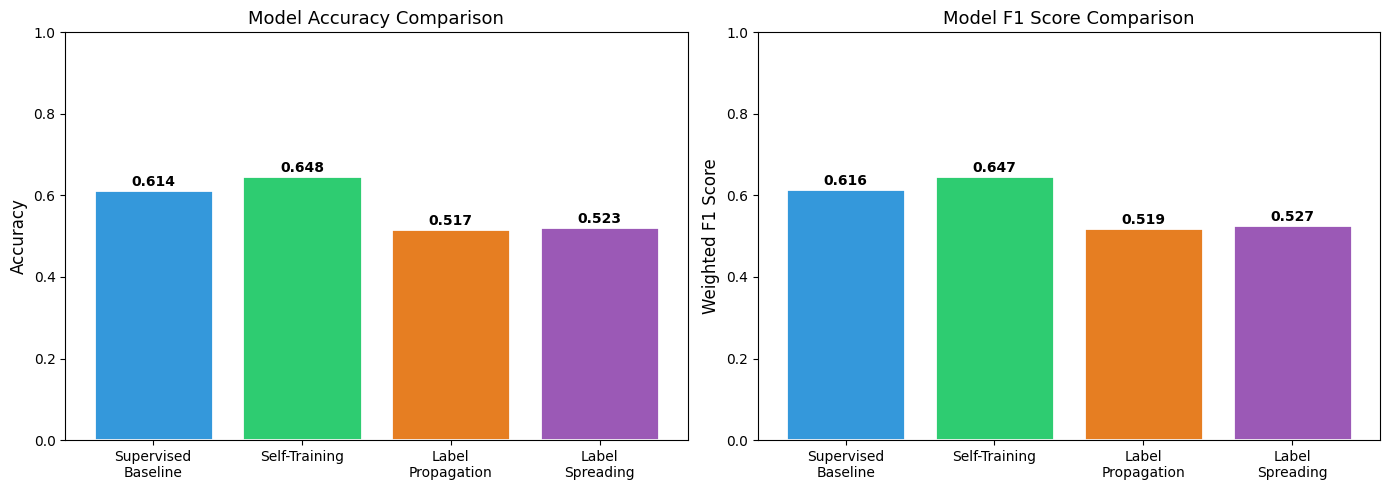

In [15]:
# --- Visual Comparison ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

model_labels = ['Supervised\nBaseline', 'Self-Training', 'Label\nPropagation', 'Label\nSpreading']
colors = ['#3498db', '#2ecc71', '#e67e22', '#9b59b6']

# Accuracy comparison
axes[0].bar(model_labels, results['Accuracy'], color=colors, edgecolor='white', linewidth=2)
axes[0].set_ylim(0, 1)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=13)
for i, v in enumerate(results['Accuracy']):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# F1 comparison  
axes[1].bar(model_labels, results['Weighted F1'], color=colors, edgecolor='white', linewidth=2)
axes[1].set_ylim(0, 1)
axes[1].set_ylabel('Weighted F1 Score', fontsize=12)
axes[1].set_title('Model F1 Score Comparison', fontsize=13)
for i, v in enumerate(results['Weighted F1']):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Confusion Matrices

In [ ]:
# --- Feature Importance from Self-Training model ---
# The base estimator inside SelfTrainingClassifier is a GradientBoosting,
# which provides feature_importances_
importances = self_training.estimator_.feature_importances_
feat_imp = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Top 15 features
top_n = 15
fig, ax = plt.subplots(figsize=(10, 7))
top_feats = feat_imp.head(top_n)
ax.barh(range(top_n), top_feats['Importance'].values, color='steelblue', edgecolor='white')
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_feats['Feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Top 15 Features — Self-Training Model', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print('\nTop 15 most important features for revenue tier prediction:')
print(top_feats[['Feature', 'Importance']].to_string(index=False))

## 7. Feature Importance Analysis

In [ ]:
# --- Confusion Matrices for all models ---
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
predictions = [
    (y_pred_supervised, 'Supervised Baseline'),
    (y_pred_self, 'Self-Training (Semi-Supervised)'),
    (y_pred_lp, 'Label Propagation'),
    (y_pred_ls, 'Label Spreading')
]
tier_labels = ['Low', 'Medium', 'High', 'Blockbuster']

for ax, (y_pred, title) in zip(axes.flat, predictions):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=tier_labels, yticklabels=tier_labels)
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_ylabel('Actual', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')

plt.suptitle('Confusion Matrices — All Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

AttributeError: 'SelfTrainingClassifier' object has no attribute 'base_estimator_'

## 8. Predict Revenue Tiers for Unlabeled Movies

In [ ]:
# --- Use the best semi-supervised model to predict unlabeled movies ---
X_unlabeled_scaled = scaler.transform(X_unlabeled)
predicted_tiers = self_training.predict(X_unlabeled_scaled)
predicted_proba = self_training.predict_proba(X_unlabeled_scaled)
max_confidence = predicted_proba.max(axis=1)

# Create results dataframe
unlabeled_predictions = df.iloc[unlabeled_idx][['title', 'release_year', 'budget', 'popularity', 'vote_average']].copy()
unlabeled_predictions['predicted_tier'] = [tier_names[t] for t in predicted_tiers]
unlabeled_predictions['confidence'] = max_confidence

print(f'Predictions for {len(unlabeled_predictions)} previously unlabeled movies:')
print(f'\nPredicted tier distribution:')
print(unlabeled_predictions['predicted_tier'].value_counts())
print(f'\nAverage confidence: {max_confidence.mean():.3f}')
print(f'High confidence (>80%): {(max_confidence > 0.8).sum()} movies')

print(f'\n--- Sample High-Confidence Predictions ---')
print(unlabeled_predictions.sort_values('confidence', ascending=False).head(15).to_string(index=False))

In [ ]:
# --- Confidence Distribution ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Confidence histogram
axes[0].hist(max_confidence, bins=40, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].axvline(0.8, color='red', linestyle='--', linewidth=2, label='80% threshold')
axes[0].set_xlabel('Prediction Confidence', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Prediction Confidence Distribution', fontsize=13)
axes[0].legend()

# Right: Predicted tier distribution
tier_counts = unlabeled_predictions['predicted_tier'].value_counts()
colors_tier = ['#e74c3c', '#f39c12', '#2ecc71', '#3498db']
axes[1].bar(tier_counts.index, tier_counts.values, color=colors_tier[:len(tier_counts)], edgecolor='white')
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Predicted Revenue Tiers (Unlabeled Movies)', fontsize=13)
for i, v in enumerate(tier_counts.values):
    axes[1].text(i, v + 20, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Save Results

In [ ]:
# --- Save predictions ---
# Combine original labels + predictions
df_output = df[['movie_id', 'title', 'release_year', 'budget', 'revenue', 'popularity', 'vote_average']].copy()
df_output['revenue_tier_label'] = df['revenue_tier'].map(tier_names)
df_output['is_predicted'] = df['revenue_tier'] == -1

# Add predictions for unlabeled movies
all_predictions = self_training.predict(scaler.transform(X))
all_proba = self_training.predict_proba(scaler.transform(X))
df_output['predicted_tier'] = [tier_names[t] for t in all_predictions]
df_output['prediction_confidence'] = all_proba.max(axis=1)

# For labeled movies, use actual tier; for unlabeled, use predicted
df_output['final_tier'] = np.where(
    df_output['is_predicted'],
    df_output['predicted_tier'],
    df_output['revenue_tier_label']
)

df_output.to_csv('../data/data_semi_supervised_predictions.csv', index=False)
print(f'Saved predictions to data/data_semi_supervised_predictions.csv')
print(f'Shape: {df_output.shape}')
print(f'\nFinal tier distribution (labeled + predicted):')
print(df_output['final_tier'].value_counts())
print(f'\nSample output:')
print(df_output.head(10).to_string(index=False))

## 10. Summary & Key Findings

### Why Semi-Supervised Learning?
- Our dataset has **72% missing revenue** — a classic semi-supervised scenario
- By leveraging unlabeled movies alongside labeled ones, we can potentially improve model generalization

### Models Compared
| Model | Type | Key Idea |
|-------|------|----------|
| Gradient Boosting | Supervised (baseline) | Trained only on labeled data |
| Self-Training | Semi-Supervised | Iteratively labels high-confidence predictions |
| Label Propagation | Semi-Supervised | Propagates labels through a similarity graph |
| Label Spreading | Semi-Supervised | Regularized variant that is more robust to noise |

### Practical Impact
- Generated revenue tier predictions for **~6,700 previously unlabeled movies**
- Predictions include confidence scores for reliability assessment
- These predictions can be used as features for downstream tasks or business analysis